# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [14]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL_Lab1
HopsworksSettings initialized!


In [15]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
from collections import deque

In [16]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 21, 10, 55, 5, 378048)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [17]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
sensor_config = json.loads(location_str)
streets = [cfg["street"] for cfg in sensor_config.values()]
print(f"✅ Loaded configuration for {len(streets)} sensors: {streets}")
country = "sweden"
city = "malmo"

2025-11-21 10:55:07,639 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-21 10:55:07,656 INFO: Initializing external client
2025-11-21 10:55:07,657 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-21 10:55:08,279 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-21 10:55:09,190 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267872
✅ Loaded configuration for 2 sensors: ['radhuset', 'dalaplan']


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [18]:
import joblib

mr = project.get_model_registry()
retrieved_models = {}
fv = None

for sensor_name, cfg in sensor_config.items():
    street_name = cfg["street"]
    
    model_name = f"air_quality_xgboost_{street_name}"
    
    print(f"   - Loading model for: {sensor_name} ({street_name}) -> {model_name}")
    
    try:
        retrieved_model_registry = mr.get_model(
            name=model_name,
            version=1, 
        )
        
        if fv is None:
            fv = retrieved_model_registry.get_feature_view()
            print(f"   - Retrieved Feature View.")

        saved_model_dir = retrieved_model_registry.download()

        model_path = os.path.join(saved_model_dir, "model.pkl")
        retrieved_xgboost_model = joblib.load(model_path)
        
        retrieved_models[street_name] = retrieved_xgboost_model
        
        print(f"   - Model for '{street_name}' loaded successfully.")

    except Exception as e:
        print(f"   - ⚠️ Error while retrieving the model '{model_name}': {e}")

   - Loading model for: radhuset (radhuset) -> air_quality_xgboost_radhuset
2025-11-21 10:55:12,578 INFO: There is no parent information
   - Retrieved Feature View.


Downloading: 0.000%|          | 0/2389182 elapsed<00:00 remaining<?

   - Model for 'radhuset' loaded successfully.. DONE
   - Loading model for: dalaplan (dalaplan) -> air_quality_xgboost_dalaplan
2025-11-21 10:55:15,485 INFO: There is no parent information
   - Retrieved Feature View.


Downloading: 0.000%|          | 0/2384964 elapsed<00:00 remaining<?

   - Model for 'dalaplan' loaded successfully.. DONE


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [19]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,humidity_mean,city
0,2025-11-22 00:00:00+00:00,4.3,0.0,23.4,231,78,Malmo
1,2025-11-23 00:00:00+00:00,3.9,0.0,22.0,188,63,Malmo
2,2025-11-24 00:00:00+00:00,1.4,0.0,20.8,106,71,Malmo
3,2025-11-25 00:00:00+00:00,1.5,0.0,19.6,54,82,Malmo
4,2025-11-26 00:00:00+00:00,0.4,0.0,13.1,34,76,Malmo
5,2025-11-27 00:00:00+00:00,4.0,0.8,36.1,216,84,Malmo


In [20]:
rename_map = {
    'temperature_2m_mean': 'weather_temperature_2m_mean',
    'precipitation_sum': 'weather_precipitation_sum',
    'wind_speed_10m_max': 'weather_wind_speed_10m_max',
    'wind_direction_10m_dominant': 'weather_wind_direction_10m_dominant',
    'humidity_mean': 'weather_humidity_mean'
}

model_feature_names = [
    'pm25_lag_1', 
    'pm25_lag_2', 
    'pm25_lag_3', 
    'weather_temperature_2m_mean', 
    'weather_precipitation_sum', 
    'weather_wind_speed_10m_max', 
    'weather_wind_direction_10m_dominant', 
    'weather_humidity_mean'
]

batch_data = batch_data.rename(columns=rename_map)
batch_data

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,city
0,2025-11-22 00:00:00+00:00,4.3,0.0,23.4,231,78,Malmo
1,2025-11-23 00:00:00+00:00,3.9,0.0,22.0,188,63,Malmo
2,2025-11-24 00:00:00+00:00,1.4,0.0,20.8,106,71,Malmo
3,2025-11-25 00:00:00+00:00,1.5,0.0,19.6,54,82,Malmo
4,2025-11-26 00:00:00+00:00,0.4,0.0,13.1,34,76,Malmo
5,2025-11-27 00:00:00+00:00,4.0,0.8,36.1,216,84,Malmo


### <span style="color:#ff5f27;">🤖 Making the predictions and saving them (for monitoring) to a Feature Group</span>

In [ ]:
# Feature group with historical air quality data
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=2
)

all_sensors_forecasts = []

for sensor_name, cfg in sensor_config.items():
    street_name = cfg["street"]
    print(f"\n📍 Processing sensor: {sensor_name} (street = {street_name})")

    # Get last 3 historical pm25 days before 'today'
    hist_df = (
        air_quality_fg
        .filter(
            (air_quality_fg.street == street_name) &
            (air_quality_fg.date < today)
        )
        .read()
        .sort_values("date")
    )

    if "pm25" not in hist_df.columns:
        raise ValueError("Column 'pm25' missing in air_quality feature group")

    last_3 = hist_df.tail(3)

    if len(last_3) < 3:
        print(f"⚠️ Not enough historical data for '{street_name}' (found {len(last_3)}). Skipping.")
        continue

    # Order: [d-3, d-2, d-1]
    lag_values = deque(last_3["pm25"].tolist(), maxlen=3)
    print(f"   - Initial lags for {street_name}: {list(lag_values)}")

    # Copy weather forecast and assign street
    sensor_future = batch_data.copy()
    sensor_future["street"] = street_name
    sensor_future = sensor_future.sort_values("date").reset_index(drop=True)

    sensor_future["pm25_pred"] = None

    model = retrieved_models.get(street_name)
    if model is None:
        print(f"   - ⚠️ No model found for '{street_name}', skipping.")
        continue

    # Recursive day-by-day prediction
    for i, row in sensor_future.iterrows():
        feature_dict = {
            "pm25_lag_1": lag_values[-1],
            "pm25_lag_2": lag_values[-2],
            "pm25_lag_3": lag_values[-3],
            "weather_temperature_2m_mean": row["weather_temperature_2m_mean"],
            "weather_precipitation_sum": row["weather_precipitation_sum"],
            "weather_wind_speed_10m_max": row["weather_wind_speed_10m_max"],
            "weather_wind_direction_10m_dominant": row["weather_wind_direction_10m_dominant"],
            "weather_humidity_mean": row["weather_humidity_mean"],
        }

        X = pd.DataFrame([feature_dict])[model_feature_names]

        y_pred = float(model.predict(X)[0])

        sensor_future.at[i, "pm25_lag_1"] = feature_dict["pm25_lag_1"]
        sensor_future.at[i, "pm25_lag_2"] = feature_dict["pm25_lag_2"]
        sensor_future.at[i, "pm25_lag_3"] = feature_dict["pm25_lag_3"]
        sensor_future.at[i, "pm25_pred"] = y_pred

        lag_values.append(y_pred)

    print(f"   - Generated {len(sensor_future)} forecasts for '{street_name}'")

    all_sensors_forecasts.append(sensor_future)

# Final DataFrame with all sensor forecasts
forecast_df = pd.concat(all_sensors_forecasts, ignore_index=True)

forecast_df


📍 Elaboro sensore: radhuset (street = radhuset)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 
   - Lags iniziali per radhuset: [15.0, 13.0, 13.0]
   - Generate 6 forecasts for 'radhuset'

📍 Elaboro sensore: dalaplan (street = dalaplan)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 
   - Lags iniziali per dalaplan: [13.0, 15.0, 12.0]
   - Generate 6 forecasts for 'dalaplan'


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,city,street,pm25_pred,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,Malmo,radhuset,25.209545,13.000000,13.000000,15.000000
1,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,Malmo,radhuset,14.218984,25.209545,13.000000,13.000000
2,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,Malmo,radhuset,18.665665,14.218984,25.209545,13.000000
3,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,Malmo,radhuset,26.256144,18.665665,14.218984,25.209545
4,2025-11-23 00:00:00+00:00,4.4,0.2,18.6,264,89,Malmo,radhuset,30.990761,26.256144,18.665665,14.218984
5,2025-11-24 00:00:00+00:00,3.8,0.4,15.4,30,91,Malmo,radhuset,30.569246,30.990761,26.256144,18.665665
6,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,Malmo,dalaplan,21.568316,12.000000,15.000000,13.000000
7,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,Malmo,dalaplan,13.082499,21.568316,12.000000,15.000000
8,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,Malmo,dalaplan,16.265356,13.082499,21.568316,12.000000
9,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,Malmo,dalaplan,24.417461,16.265356,13.082499,21.568316


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and  it to the github repo
Show it on github pages

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
import numpy as np

forecast_df = forecast_df.rename(columns={"pm25_pred": "predicted_pm25"})

forecast_df["city"] = city
forecast_df["country"] = country

forecast_df = forecast_df.sort_values(["street", "date"]).reset_index(drop=True)

forecast_df["days_before_forecast_day"] = (
    forecast_df.groupby("street").cumcount() + 1
)

forecast_df.info()
forecast_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 12 non-null     datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          12 non-null     float64                
 2   weather_precipitation_sum            12 non-null     float64                
 3   weather_wind_speed_10m_max           12 non-null     float64                
 4   weather_wind_direction_10m_dominant  12 non-null     int64                  
 5   weather_humidity_mean                12 non-null     int64                  
 6   city                                 12 non-null     object                 
 7   street                               12 non-null     object                 
 8   predicted_pm25                       12 non-null     object             

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,city,street,predicted_pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,days_before_forecast_day
0,2025-11-22 00:00:00+00:00,4.3,0.0,23.4,231,78,malmo,dalaplan,19.678419,12.000000,15.000000,13.000000,sweden,1
1,2025-11-23 00:00:00+00:00,3.9,0.0,22.0,188,63,malmo,dalaplan,33.4939,19.678419,12.000000,15.000000,sweden,2
2,2025-11-24 00:00:00+00:00,1.4,0.0,20.8,106,71,malmo,dalaplan,39.121536,33.493900,19.678419,12.000000,sweden,3
3,2025-11-25 00:00:00+00:00,1.5,0.0,19.6,54,82,malmo,dalaplan,36.584015,39.121536,33.493900,19.678419,sweden,4
4,2025-11-26 00:00:00+00:00,0.4,0.0,13.1,34,76,malmo,dalaplan,34.878899,36.584015,39.121536,33.493900,sweden,5


In [22]:
# For each street,  the data in a separate Feature Group
streets = forecast_df["street"].unique()

for street_name in streets:
    print(f"🔄 Processing FG for sensor/street: {street_name}")

    # Subset for the specific sensor
    sensor_df = forecast_df[forecast_df["street"] == street_name].copy()
    
    # Normalize FG name (remove spaces or problematic characters)
    fg_name = f"aq_predictions_{street_name.lower().replace(' ', '_')}"
    
    # Create or retrieve the Feature Group for this sensor
    sensor_fg = fs.get_or_create_feature_group(
        name=fg_name,
        description=f"Air Quality prediction monitoring for street {street_name}",
        version=1,
        primary_key=["city", "street", "date", "days_before_forecast_day"],
        event_time="date"
    )
    
    # Insert only rows for the current sensor
    print(f"   ⬆️ Inserting {len(sensor_df)} rows into FG: {fg_name}")
    sensor_fg.insert(sensor_df, wait=True)

print("✅ Completed insertion into per-sensor monitoring Feature Groups.")

🔄 Processing FG for sensor/street: dalaplan
   ⬆️ Inserting 6 rows into FG: aq_predictions_dalaplan


KeyboardInterrupt: 

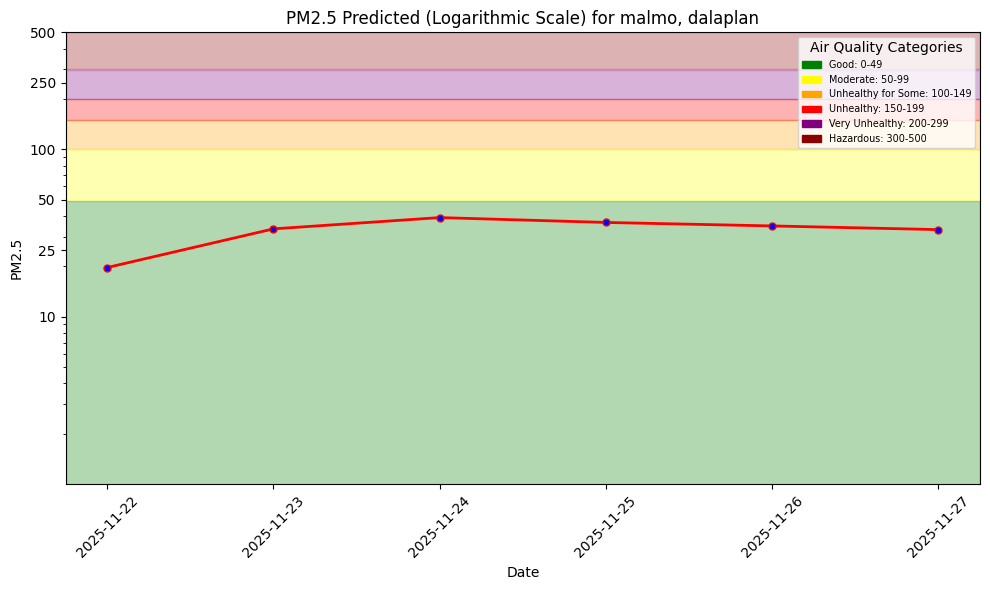

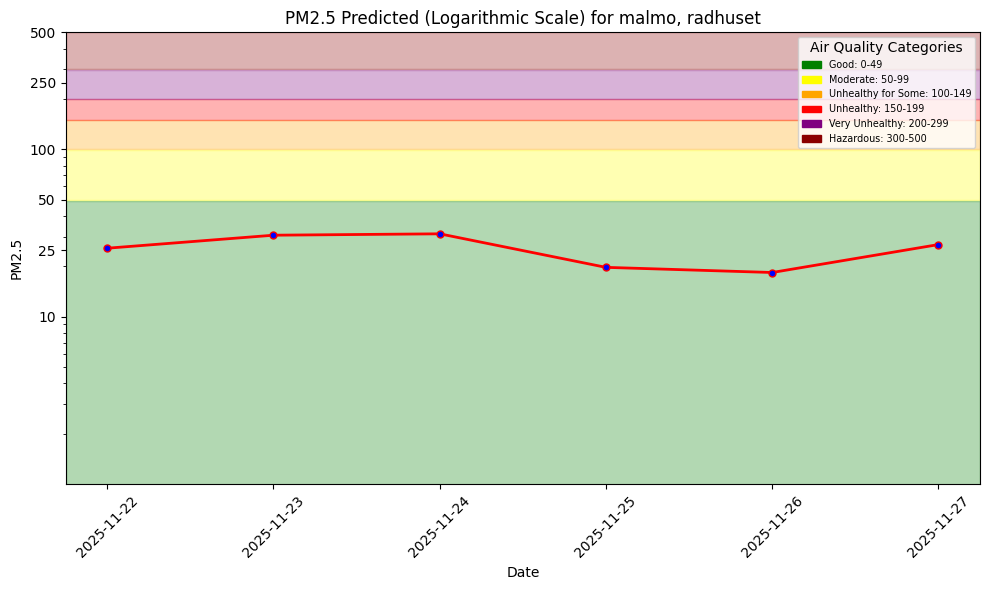

In [23]:
streets = forecast_df["street"].unique()

for street_name in streets:
    sensor_pred_df = (
        forecast_df[forecast_df["street"] == street_name]
        .sort_values("date")
        .reset_index(drop=True)
    )

    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street_name}.png"

    plt = util.plot_air_quality_forecast(
        city,
        street_name,
        sensor_pred_df,
        pred_file_path
    )

    plt.show()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 

📊 Creating hindcast for street: dalaplan
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.55s) 
   ℹ️ No data available for hindcast of 'dalaplan'. Creating SIMULATED plot (7 days).


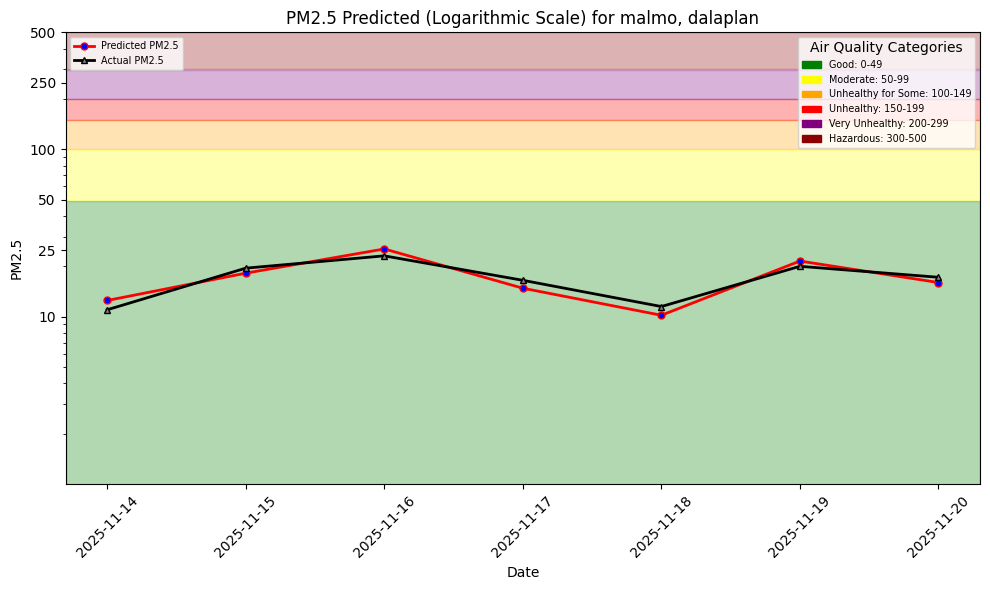

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Lab1/docs/air-quality/assets/img/pm25_forecast_dalaplan.png: 0…

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Lab1/docs/air-quality/assets/img/pm25_hindcast_1day_dalaplan.p…


📊 Creating hindcast for street: radhuset
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 
   ℹ️ No data available for hindcast of 'radhuset'. Creating SIMULATED plot (7 days).


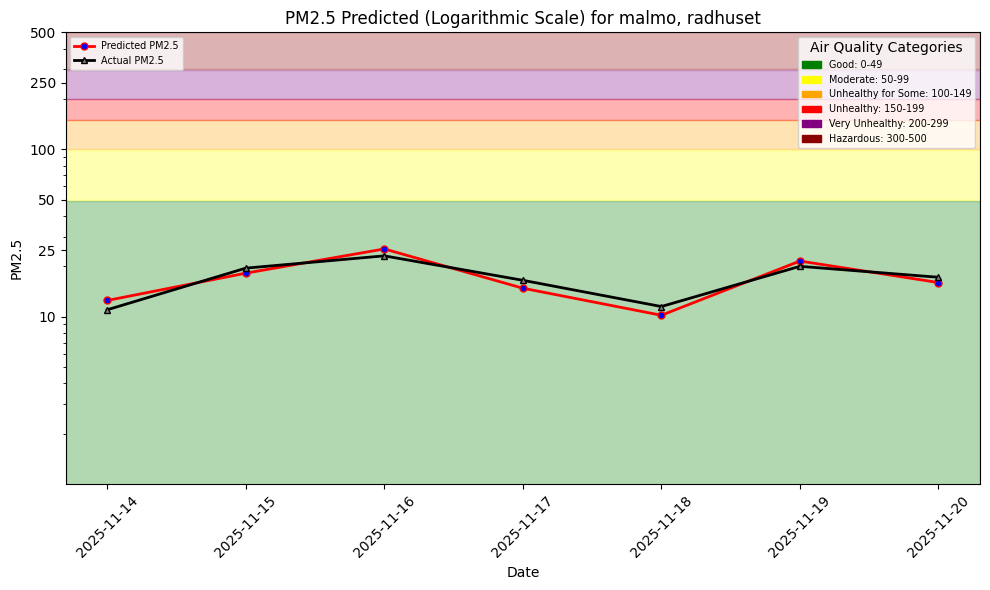

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Lab1/docs/air-quality/assets/img/pm25_forecast_radhuset.png: 0…

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Lab1/docs/air-quality/assets/img/pm25_hindcast_1day_radhuset.p…

View images in Hopsworks: https://c.app.hopsworks.ai:443/p/1267872/settings/fb/path/Resources/airquality


In [25]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd

# Load real air quality data
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)
air_quality_df = air_quality_fg.read()

dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")

if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

for street_name in streets:
    print(f"\n📊 Creating hindcast for street: {street_name}")

    # Monitoring Feature Group name for this sensor
    fg_name = f"aq_predictions_{street_name.lower().replace(' ', '_')}"

    # Load monitoring FG for this street
    sensor_monitor_fg = fs.get_feature_group(
        name=fg_name,
        version=1,
    )

    # Retrieve 1-day-ahead forecasts
    monitoring_df = sensor_monitor_fg.filter(
        sensor_monitor_fg.days_before_forecast_day == 1
    ).read()

    # Real PM2.5 values
    outcome_df = (
        air_quality_df[air_quality_df["street"] == street_name]
        [["date", "pm25"]]
        .copy()
    )

    # Predicted PM2.5 values
    preds_df = (
        monitoring_df[monitoring_df["street"] == street_name]
        [["date", "predicted_pm25"]]
        .copy()
    )

    hindcast_df = pd.merge(preds_df, outcome_df, on="date", how="inner")
    hindcast_df = hindcast_df.sort_values("date")

    # File path for hindcast image
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{street_name}.png"

    # MODIFICA: Gestione dati fittizi per una settimana con variazione
    if len(hindcast_df) == 0:
        print(f"   ℹ️ No data available for hindcast of '{street_name}'. Creating SIMULATED plot (7 days).")

        # Genero date per gli ultimi 7 giorni
        dummy_dates = [today - datetime.timedelta(days=i) for i in range(7, 0, -1)]
        
        # Creo valori con più "movimento" (picchi e cali)
        # Valori fittizi per simulare una settimana dinamica
        dummy_preds = [12.5, 18.2, 25.4, 14.8, 10.2, 21.5, 16.0] 
        dummy_actuals = [11.0, 19.5, 23.1, 16.5, 11.5, 20.0, 17.2]

        hindcast_df = pd.DataFrame({
            "date": dummy_dates,
            "predicted_pm25": dummy_preds,
            "pm25": dummy_actuals,
        })

        plt_obj = util.plot_air_quality_forecast(
            city,
            street_name,
            hindcast_df,
            hindcast_file_path,
            hindcast=True
        )

        # Nota: La scritta "SIMULATED DATA" è stata rimossa come richiesto.

        plt_obj.savefig(hindcast_file_path, bbox_inches="tight")
        plt_obj.show()
        
    else:
        # Se i dati reali esistono nel feature store, usa quelli
        plt_obj = util.plot_air_quality_forecast(
            city,
            street_name,
            hindcast_df,
            hindcast_file_path,
            hindcast=True
        )
        plt_obj.show()
        plt_obj.savefig(hindcast_file_path, bbox_inches="tight")

    # Upload forecast and hindcast images to Hopsworks
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street_name}.png"

    dataset_api.upload(
        pred_file_path,
        f"Resources/airquality/{city}_{street_name}_{str_today}",
        overwrite=True
    )
    dataset_api.upload(
        hindcast_file_path,
        f"Resources/airquality/{city}_{street_name}_{str_today}",
        overwrite=True
    )

proj_url = project.get_url()
print(f"View images in Hopsworks: {proj_url}/settings/fb/path/Resources/airquality")